In [89]:
import sys
import os 

os.environ["CONFIG_PATHS"] = "../../configs/self_play.yaml"
os.environ["CONFIG_OVERRIDES"] = 'game.moves_directory="../../data/moves_10"'
sys.path.append("../../src")

import matplotlib.pyplot as plt
import scipy.stats
import numpy as np
import torch
import glob

from neural_net import NeuralNet
from configuration import config, moves_data
from analysis import load_events, filter_events
from display import Display
import player_pov_helpers
from training.load_games import load_games_new

In [2]:
MOVES = moves_data()

In [3]:
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

In [88]:
events = load_events(max(glob.glob("../../data/2024-12-05_00-58-47-arena-for-one-vs-two-with-temp-0.3-and-randoms/logs_*.txt")))

Start time: 1733389160.453887


In [ ]:
for event in events:
    if event.name == "game_end":
        print("Completed a game.")

In [ ]:
for event in events:
    if event.name == "loaded_model":
        print(event.params["model_name"])

In [7]:
mcts_reports = [e.params for e in filter_events(events, "mcts_report")]
ucb_reports = [e.params for e in filter_events(events, "ucb_report")]

In [8]:
target_count = 400

count = 0
for i, report in enumerate(ucb_reports):
    if np.sum(np.array(report["board"])) == 0:
        if count == target_count:
            break
        count += 1

report_index = i

report = ucb_reports[report_index]

In [9]:
report = mcts_reports[52]

In [ ]:
board = np.array(report["board"])
children_visit_counts = np.array(report["children_visit_counts"])
children_value_sums = np.array(report["children_value_sums"])
children_priors = np.array(report["children_priors"])
array_index_to_move_index = np.array(report["array_index_to_move_index"])
values = np.array(report["values"])
player = report["player"]

Display(board, MOVES["new_occupieds"][array_index_to_move_index[np.argmax(children_visit_counts)]]).show()
print(player)
print(values)
print(np.sum(board, axis=(1,2)))

In [ ]:
values_history = []
for report in mcts_reports[40:62]:
    values_history.append(np.array(report["values"]))
values_history = np.array(values_history)

plt.figure(figsize=(10, 6))
for i in range(len(values_history[0])):
    plt.plot(range(len(values_history)), values_history[:, i], label=f'Value {i}')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.title('Values History Over Time')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


In [ ]:
plt.figure(figsize=(10, 6))
plt.bar(range(len(children_visit_counts)), children_visit_counts, color='g')
plt.xlabel('Move Index')
plt.ylabel('Visit Counts')
plt.title('Bar Chart of Children Visit Counts')
plt.xticks(ticks=range(0, len(children_visit_counts), max(1, len(children_visit_counts)//10)))
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

sum(children_visit_counts)

In [ ]:
exploitation_scores = np.divide(
    np.array(children_value_sums[player]),
    np.array(children_visit_counts),
    where=children_visit_counts > 0
)
exploitation_scores[children_visit_counts <= 0] = values[player]

sqrt_total_visit_count = np.sqrt(np.sum(children_visit_counts) + 1)
exploration_scores = 1.4 * np.array(children_priors) * sqrt_total_visit_count / (1 + np.array(children_visit_counts))

# Create a stacked bar chart
plt.figure(figsize=(10, 6))
indices = range(len(exploitation_scores))
plt.bar(indices, exploitation_scores, label='Exploitation Scores', color='b')
plt.bar(indices, exploration_scores, bottom=exploitation_scores, label='Exploration Scores', color='r')

plt.xlabel('Move Index')
plt.ylabel('Scores')
plt.title('Stacked Bar Chart of Exploitation and Exploration Scores')
plt.xticks(ticks=range(0, len(exploitation_scores), max(1, len(exploitation_scores)//10)))
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.legend()
plt.show()


In [ ]:
plt.figure(figsize=(10, 6))
bottom = np.zeros(len(children_value_sums[0]))
for p in range(4):
    average_value_sums = np.array(children_value_sums[p]) / (np.array(children_visit_counts) + 1e-9)  # Avoid division by zero
    plt.bar(range(len(average_value_sums)), average_value_sums, bottom=bottom, alpha=0.5, label=f'Player {p}')
    bottom += average_value_sums
plt.xlabel('Move Index')
plt.ylabel('Average Value Sums')
plt.title('Stacked Bar Chart of Average Value Sums by Player')
plt.xticks(ticks=range(0, len(average_value_sums), max(1, len(average_value_sums)//10)))
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.legend()
plt.show()

print(values)
print(player)

In [ ]:
plt.figure(figsize=(10, 6))
plt.bar(range(len(children_priors)), children_priors, color='c')
plt.xlabel('Move Index')
plt.ylabel('Children Prior')
plt.title('Bar Chart of Children Prior')
plt.xticks(ticks=range(0, len(children_priors), max(1, len(children_priors)//10)))
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
model = NeuralNet(config()["networks"]["default"])
# model.load_state_dict(torch.load("../../data/2024-11-19_08-38-28-extracted/models/2024-11-20_09-34-23_478500.pt", weights_only=True))
# model.load_state_dict(torch.load("../../data/2024-11-20_17-29-54-solitude/models/2024-11-20_08-24-43_975055.pt", weights_only=True))
# model.load_state_dict(torch.load("../../data/2024-11-20_14-10-24-survival/models/2024-11-20_02-24-48_055438_s105769.pt", weights_only=True))
# model.load_state_dict(torch.load("../../data/2024-11-20_14-10-24-survival/models/2024-11-20_09-34-23_478500_s313486.pt", weights_only=True))
model.load_state_dict(torch.load("../../data/2024-11-22_00-28-28-overbragging/models/2024-11-22_09-47-50_646610.pt", weights_only=True))

values_logits, policies_logits = model(torch.Tensor(
    player_pov_helpers.occupancies_to_player_pov(board, player)
).unsqueeze(0))

values_logits = values_logits[0].detach().numpy()
policy_logits = policies_logits[0].detach().numpy()

player_pov_values = player_pov_helpers.values_to_player_pov(
    softmax(values_logits),
    -player,
)
policy = softmax(policy_logits[
    player_pov_helpers.moves_indices_to_player_pov(
        array_index_to_move_index,
        player
    )
])

plt.figure(figsize=(10, 6))
plt.bar(range(len(policy)), policy, color='c')
plt.xlabel('Move Index')
plt.ylabel('Policy')
plt.title('Bar Chart of Network Policy')
plt.xticks(ticks=range(0, len(policy), max(1, len(policy)//10)))
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

print(values)

In [ ]:
top_10_indices = np.argsort(children_priors)[-10:][::-1]
for i in top_10_indices:
    print(i, np.sum(MOVES["new_occupieds"][i]))

In [4]:
import glob

directory_with_temp_one = "/Users/shivamsarodia/Dev/blockus/data/2024-12-04_22-41-02-arena-for-sampling-ratio-one-v-two-self-play-generated"
directory_with_randoms = "/Users/shivamsarodia/Dev/blockus/data/2024-12-05_00-58-47-arena-for-one-vs-two-with-temp-0.3-and-randoms"

temp_one_gamedata = load_games_new(glob.glob(directory_with_temp_one + "/games/*.npz"))
randoms_gamedata = load_games_new(glob.glob(directory_with_randoms + "/games/*.npz"))

In [42]:
ratio_one_model_path = "/Users/shivamsarodia/Dev/blockus/data/2024-11-23_00-37-50-doublehandedness/models/000652863.pt"
ratio_two_model_path = "/Users/shivamsarodia/Dev/blockus/data/2024-12-04_00-53-48-self-play-for-sampling-ratio-two/models/000650000.pt"

ratio_one_model = NeuralNet(config()["networks"]["default"])
ratio_one_model.load_state_dict(torch.load(ratio_one_model_path, weights_only=True))
ratio_one_model.to("mps")
ratio_one_model.eval()

ratio_two_model = NeuralNet(config()["networks"]["default"])
ratio_two_model.load_state_dict(torch.load(ratio_two_model_path, weights_only=True))
ratio_two_model.to("mps")
ratio_two_model.eval()

print("done")

done


In [52]:
for model_name in ["ratio_one_model", "ratio_two_model"]:
    for gamedata_name in ["randoms_gamedata", "temp_one_gamedata"]:
        for gamedata_field in ["values", "policies"]:
            gamedata = eval(gamedata_name)
            model = eval(model_name)

            index = {
                "values": 0,
                "policies": 1,
            }[gamedata_field]

            # Storing policy logits uses way too much memory
            with torch.inference_mode():
                pred_logits = model(torch.Tensor(gamedata["boards"][:60000]).to("mps"))[index]
                # pred_policy_logits = model(torch.Tensor(gamedata["boards"][:60000]).to("mps"))[1]

            # pred_winners = np.argmax(pred_value_logits.numpy(force=True), axis=1)
            # winners = np.argmax(randoms_gamedata["values"][60000:], axis=1)
            # np.sum(winners == pred_winners) / len(winners)

            pred_max = np.argmax(pred_logits.numpy(force=True), axis=1)
            real_max = np.argmax(gamedata[gamedata_field][:60000], axis=1)
            result = np.sum(pred_max == real_max) / len(pred_max)

            print(model_name, gamedata_name, gamedata_field, result)

ratio_one_model randoms_gamedata values 0.68205
ratio_one_model randoms_gamedata policies 0.6298833333333334
ratio_one_model temp_one_gamedata values 0.6062249116290216
ratio_one_model temp_one_gamedata policies 0.6631118566892337
ratio_two_model randoms_gamedata values 0.72475
ratio_two_model randoms_gamedata policies 0.6440333333333333
ratio_two_model temp_one_gamedata values 0.630100053921275
ratio_two_model temp_one_gamedata policies 0.6928284704331675


I wanted to evaluate whether the difference in relative performance between both models can better explained by a difference in relative performance of each model in predicting the winner of the game. 

Hypothesis: Ratio two model bested ratio one model by less in a game with random players because the difference between ratio two model and ratio one model's ability to predict the outcome of the game is lower when there's random players.

Here's what I found when I printed the % of the time that the predicted winner (and winner move) matched the real winner (and winner move):

ratio_one_model randoms_gamedata values 0.68205
ratio_two_model randoms_gamedata values 0.72475
^ Difference = 4.27%

ratio_one_model randoms_gamedata policies 0.6298833333333334
ratio_two_model randoms_gamedata policies 0.6440333333333333
^ Difference = 1.41%

ratio_one_model temp_one_gamedata values 0.6062249116290216
ratio_two_model temp_one_gamedata values 0.630100053921275
^ Difference = 2.388%

ratio_one_model temp_one_gamedata policies 0.6631118566892337
ratio_two_model temp_one_gamedata policies 0.6928284704331675
^ Difference = 2.97%



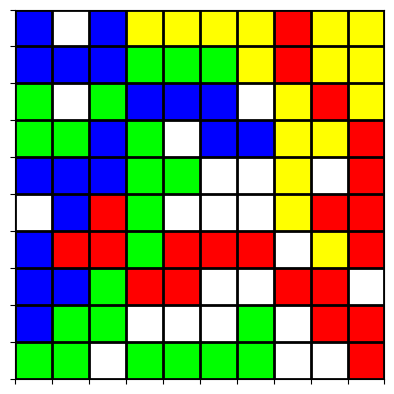

[19 16 21 22]


In [112]:
index = 12
player = {
    0: 2,
    1: 3,
    2: 2,
    3: 3,
    4: 2,
    5: 3,
    6: 2,
    7: 3,
    8: 2,
    9: 3,
    10: 2,
    11: 3,
    12: 3,
}[index]

universal_board = player_pov_helpers.occupancies_to_player_pov(
    randoms_gamedata["boards"][index],
    -player,
)
Display(universal_board).show()

print(np.sum(universal_board, axis=(1,2)))

In [114]:
count = 0

for e in events:
    if e.name == "game_result":
        print(e.params)
        count += 1
        if count > 5:
            break

[['random', 0.0], ['one', 1.0], ['random', 0.0], ['two', 0.0]]
[['random', 0.0], ['random', 0.0], ['two', 1.0], ['one', 0.0]]
[['random', 0.0], ['two', 0.0], ['one', 1.0], ['random', 0.0]]
[['random', 0.0], ['two', 1.0], ['random', 0.0], ['one', 0.0]]
[['two', 1.0], ['random', 0.0], ['one', 0.0], ['random', 0.0]]
[['random', 0.0], ['random', 0.0], ['two', 1.0], ['one', 0.0]]
